<a href="https://colab.research.google.com/github/pedrohcmds/obitos_covid_ms/blob/main/notebooks/Analise_de_S%C3%A9rie_Temporal_e_Previs%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando Bibliotecas

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

In [51]:
dados = pd.read_csv('https://raw.githubusercontent.com/pedrohcmds/obitos_covid_ms/main/dados/dados_para_analise.csv')

In [52]:
dados.head()

,data,novos_obitos_por_covid19,total_obitos_por_covid19,total_de_obitos,obitos_por_demais_causas,obitos_por_falha_respiratoria,obitos_por_causa_indeterminada,obitos_por_pneumonia,obitos_por_sars,novos_obitos,media_movel_de_obitos,media_movel_de_obitos_por_covid19
0,2020-01-01,0.0,0,37,15.0,5.0,0.0,11.0,1.0,0.0,NaN,NaN
1,2020-01-02,0.0,0,68,18.0,3.0,0.0,5.0,0.0,31.0,NaN,NaN
2,2020-01-03,0.0,0,107,21.0,6.0,0.0,7.0,0.0,39.0,NaN,NaN
3,2020-01-04,0.0,0,148,18.0,4.0,0.0,11.0,0.0,41.0,NaN,NaN
4,2020-01-05,0.0,0,184,22.0,5.0,0.0,4.0,0.0,36.0,NaN,NaN


# Decompondo séries temporais

In [53]:
dados.data = pd.to_datetime(dados.data)

In [54]:
dados['mes'] = dados.data.dt.month
dados['dia'] = dados.data.dt.day
dados['dia_da_semana'] = dados.data.dt.dayofweek

In [55]:
dados.head()

,data,novos_obitos_por_covid19,total_obitos_por_covid19,total_de_obitos,obitos_por_demais_causas,obitos_por_falha_respiratoria,obitos_por_causa_indeterminada,obitos_por_pneumonia,obitos_por_sars,novos_obitos,media_movel_de_obitos,media_movel_de_obitos_por_covid19,mes,dia,dia_da_semana
0,2020-01-01,0.0,0,37,15.0,5.0,0.0,11.0,1.0,0.0,NaN,NaN,1,1,2
1,2020-01-02,0.0,0,68,18.0,3.0,0.0,5.0,0.0,31.0,NaN,NaN,1,2,3
2,2020-01-03,0.0,0,107,21.0,6.0,0.0,7.0,0.0,39.0,NaN,NaN,1,3,4
3,2020-01-04,0.0,0,148,18.0,4.0,0.0,11.0,0.0,41.0,NaN,NaN,1,4,5
4,2020-01-05,0.0,0,184,22.0,5.0,0.0,4.0,0.0,36.0,NaN,NaN,1,5,6


# Configurando Gráficos

In [56]:
sns.set_style('darkgrid')
sns.set_palette('icefire')

# Plotando Gráficos

Text(0.5, 0, 'Tempo')

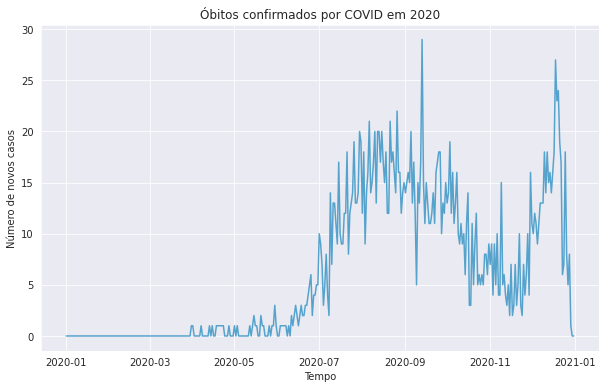

In [57]:
ax = sns.lineplot(x='data', y='novos_obitos_por_covid19', data=dados)
ax.figure.set_size_inches(10,6)
ax.set_title('Óbitos confirmados por COVID em 2020')
ax.set_ylabel('Número de novos casos')
ax.set_xlabel('Tempo')

In [58]:
dados_julho = dados.query('mes == 7')
dados_agosto = dados.query('mes == 8')

# Decomposição Mensal

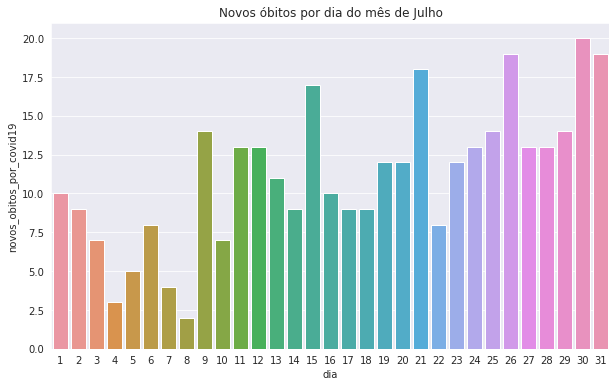

In [59]:
ax = sns.barplot(x='dia', y='novos_obitos_por_covid19', data=dados_julho)
ax.set_title('Novos óbitos por dia do mês de Julho')
ax.figure.set_size_inches(10,6)

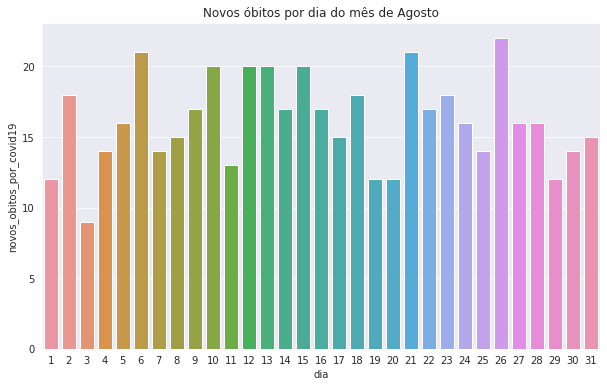

In [60]:
ax = sns.barplot(x='dia', y='novos_obitos_por_covid19', data=dados_agosto)
ax.set_title('Novos óbitos por dia do mês de Agosto')
ax.figure.set_size_inches(10,6)

# Decomposição Semanal

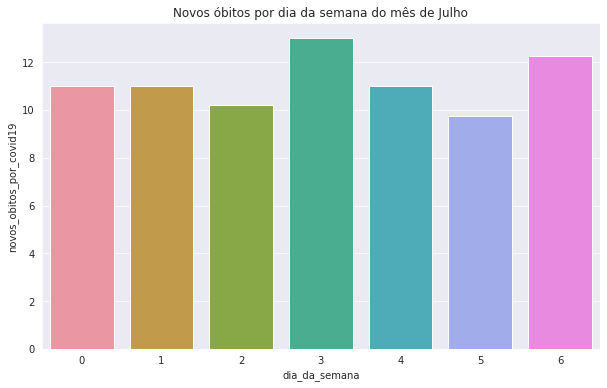

In [61]:
ax = sns.barplot(x='dia_da_semana', y='novos_obitos_por_covid19', ci=False, data=dados_julho)
ax.set_title('Novos óbitos por dia da semana do mês de Julho')
ax.figure.set_size_inches(10,6)

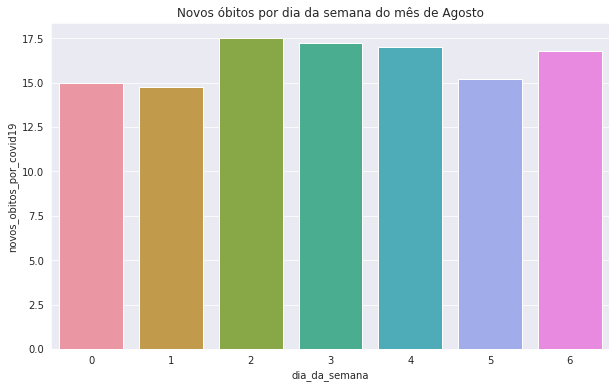

In [62]:
ax = sns.barplot(x='dia_da_semana', y='novos_obitos_por_covid19', ci=False, data=dados_agosto)
ax.set_title('Novos óbitos por dia da semana do mês de Agosto')
ax.figure.set_size_inches(10,6)

# Pré Análises

Aparentemente, não se vê uma grande correlação mensal ou por dias de semana. 

# Análise de Auto-correlação

In [63]:
from pandas.plotting import autocorrelation_plot

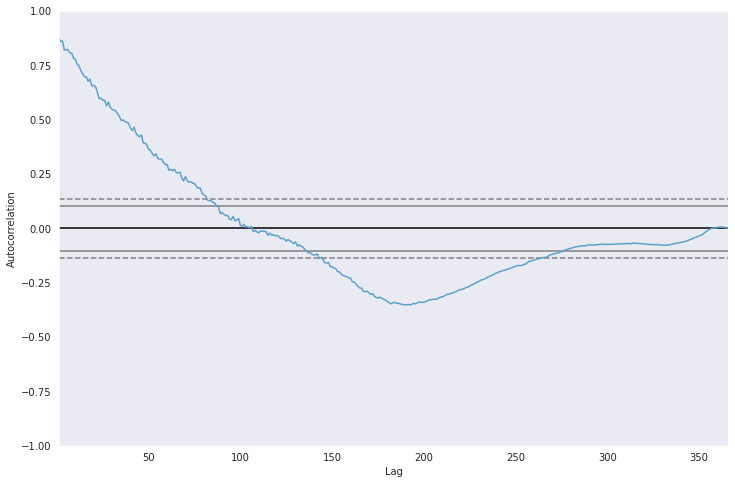

In [64]:
plt.figure(figsize=(12,8))
autocorrelation_plot(dados.novos_obitos_por_covid19)

# Usando o Faccebook Prophet

In [65]:
df = pd.DataFrame()

In [66]:
df['ds'] = dados.data[:350]
df['y'] = dados.novos_obitos_por_covid19[:350]

In [67]:
df.head()

,ds,y
0,2020-01-01,0.0
1,2020-01-02,0.0
2,2020-01-03,0.0
3,2020-01-04,0.0
4,2020-01-05,0.0


In [68]:
from fbprophet import Prophet

In [69]:
modelo = Prophet()

In [70]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
dataframe_futuro = modelo.make_future_dataframe(periods = 50)

In [73]:
previsao = modelo.predict(dataframe_futuro)

In [74]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,-1.017991,-5.344978,2.945723,-1.017991,-1.017991,-0.119530,-0.119530,-0.119530,-0.119530,-0.119530,-0.119530,0.0,0.0,0.0,-1.137521
1,2020-01-02,-1.002472,-4.509617,3.943547,-1.002472,-1.002472,0.598531,0.598531,0.598531,0.598531,0.598531,0.598531,0.0,0.0,0.0,-0.403941
2,2020-01-03,-0.986954,-5.365626,3.000753,-0.986954,-0.986954,-0.104363,-0.104363,-0.104363,-0.104363,-0.104363,-0.104363,0.0,0.0,0.0,-1.091317
3,2020-01-04,-0.971435,-5.126632,3.329493,-0.971435,-0.971435,-0.026528,-0.026528,-0.026528,-0.026528,-0.026528,-0.026528,0.0,0.0,0.0,-0.997963
4,2020-01-05,-0.955917,-4.962884,3.272512,-0.955917,-0.955917,0.032378,0.032378,0.032378,0.032378,0.032378,0.032378,0.0,0.0,0.0,-0.923539


In [75]:
df_teste = pd.DataFrame()
df_teste['ds'] = dados.data[:300]
df_teste['y'] = dados.novos_obitos_por_covid19[:300]


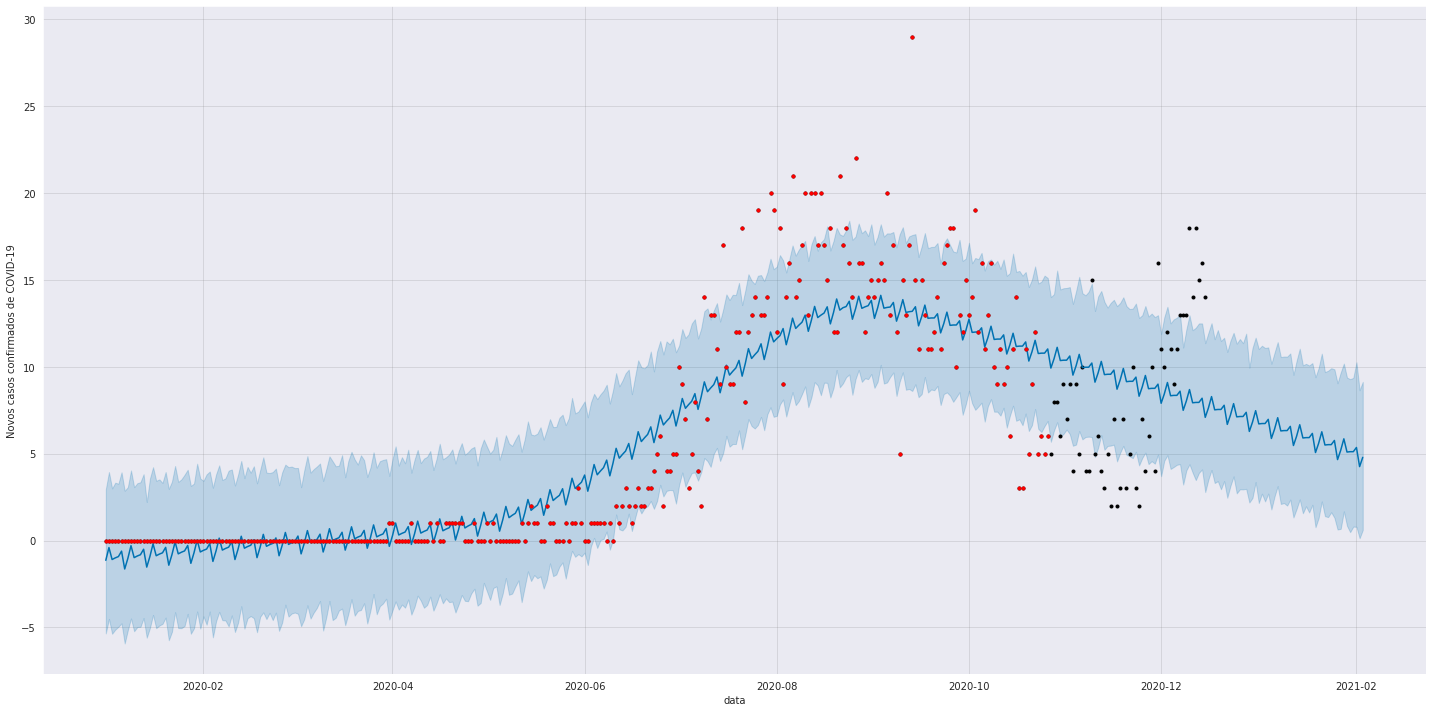

In [78]:
modelo.plot(previsao, xlabel='data', ylabel='Novos casos confirmados de COVID-19', figsize=(20,10));
plt.plot(df_teste.ds, df_teste.y, '.r')

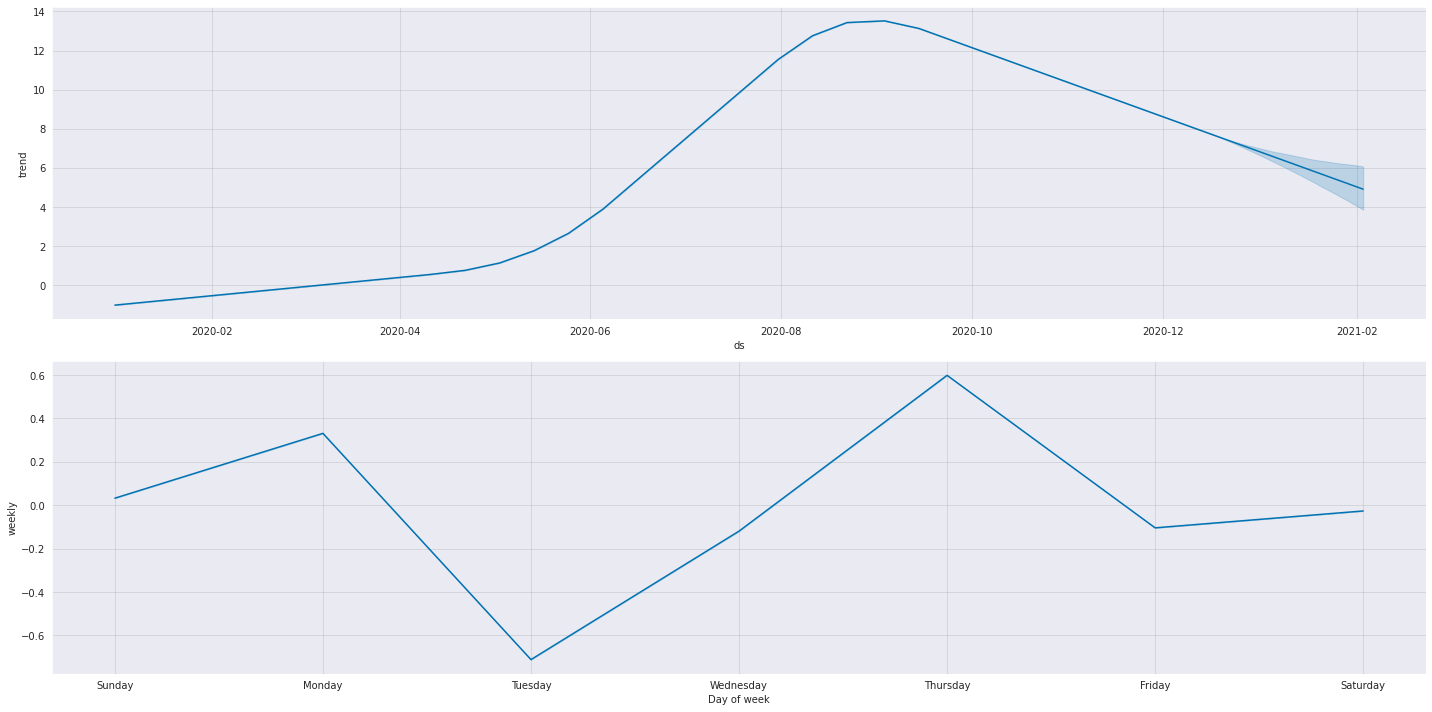

In [79]:
modelo.plot_components(previsao, figsize=(20,10));

## Análise parcial

Vê-se uma tendência forte de queda, e dentro de uma semana uma tendencia leve de queda nos casos nas terças-feiras




# Trabalhando com Changepoints

In [81]:
from fbprophet.plot import add_changepoints_to_plot

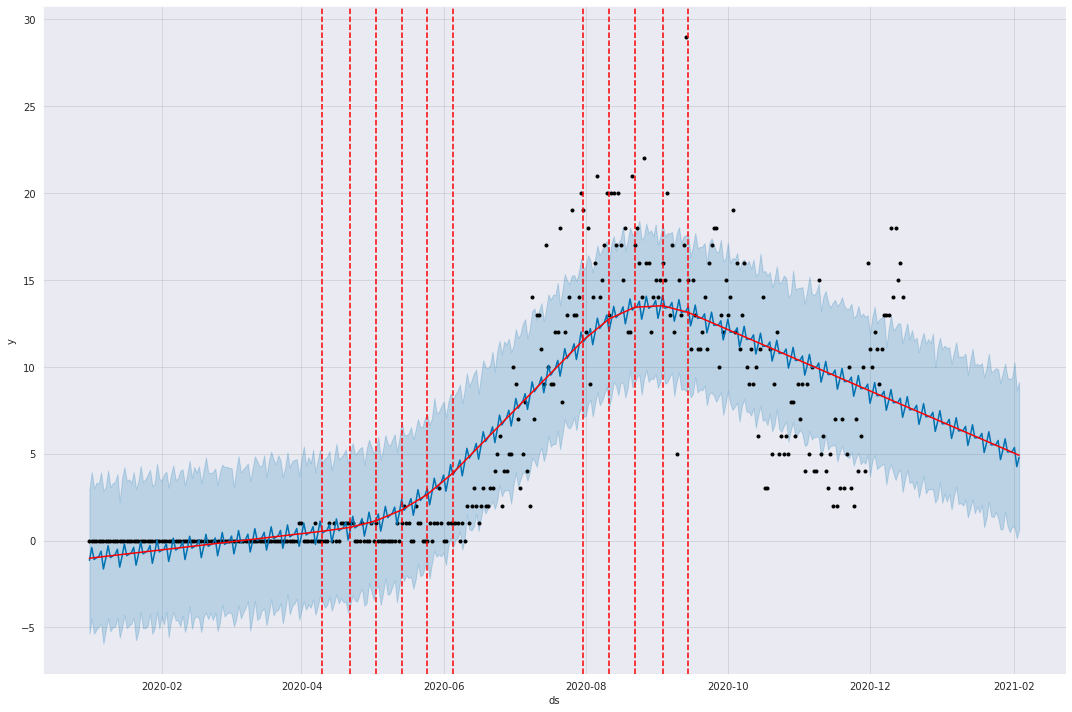

In [82]:
fig = modelo.plot(previsao, figsize=(15,10))
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

# Análise parcial

Pode-se ver dois grandes principais pontos de mudança de tendência dos dados. 

O primeiro, em abril, num aumento considerável do número de novos casos

E um outro em agosto, com uma diminuição do número de casos

Adicionando Feriados ao modelo

In [83]:
modelo = Prophet()
modelo.add_country_holidays(country_name='BR')

In [84]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
dataframefuturo = modelo.make_future_dataframe(periods=50)

In [86]:
previsao = modelo.predict(dataframefuturo)

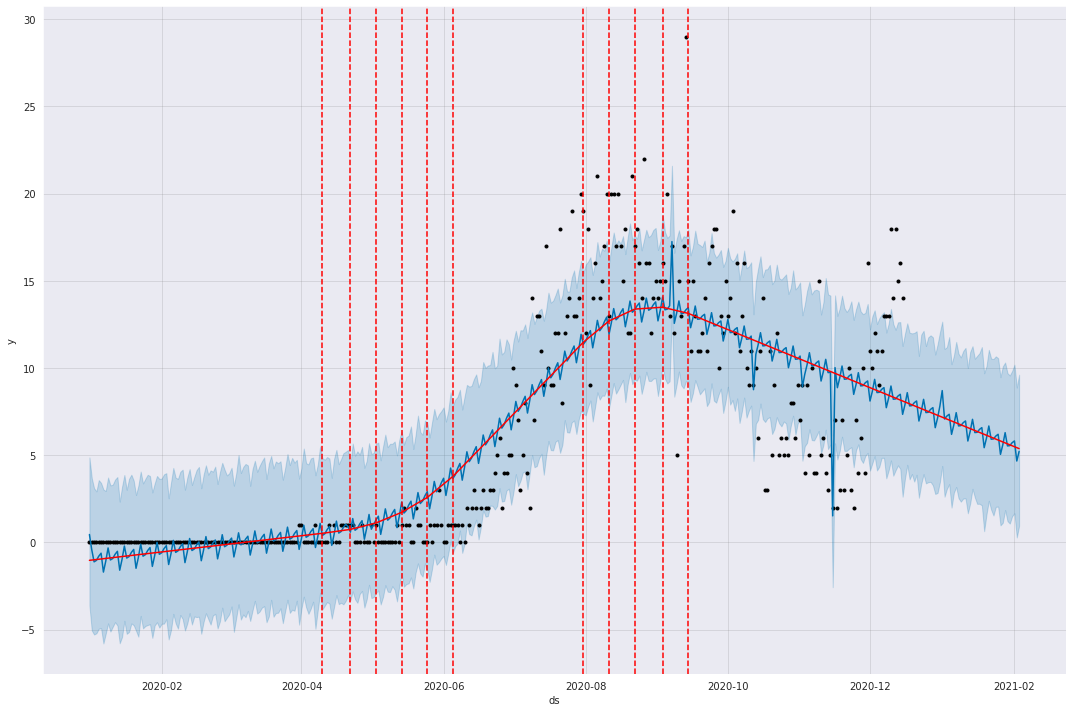

In [87]:
fig = modelo.plot(previsao, figsize=(15,10))
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

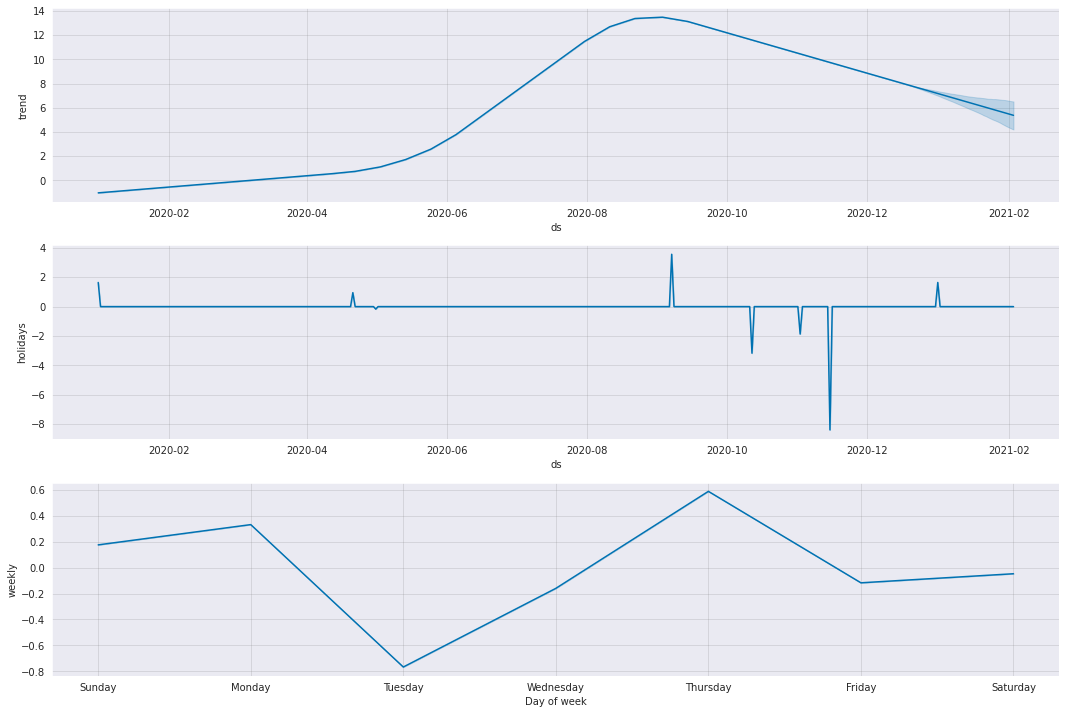

In [88]:
modelo.plot_components(previsao, figsize=(15,10));

Métricas de Erro

In [90]:
from sklearn.metrics import mean_absolute_error

In [95]:
mean_absolute_error(df['y'], previsao['yhat'][:350]).round(3)

2.265

# Análise parcial

Verifica-se um erro médio absoluto bastante baixo

# Testando modelo multiplicativo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 0.98, 'Distribuição do modelo no tempo')

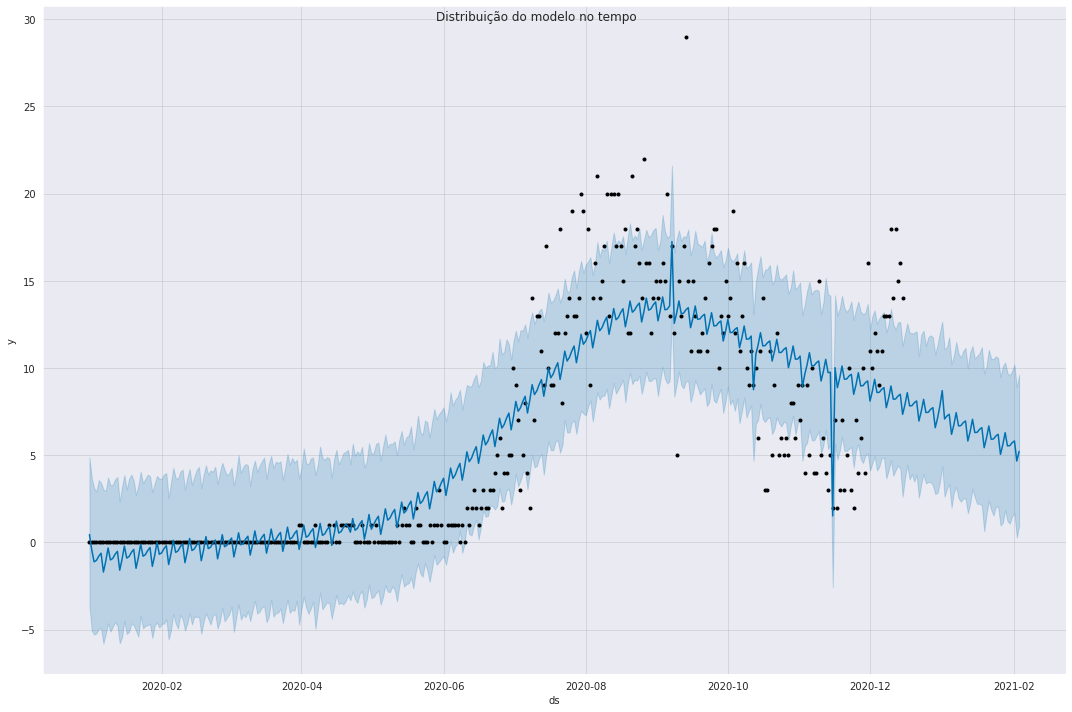

In [100]:
modelo_multiplicativo = Prophet(seasonality_mode='multiplicative')
modelo_multiplicativo.add_country_holidays(country_name='BR')
modelo_multiplicativo.fit(df)
dataframefuturo = modelo_multiplicativo.predict(dataframe_futuro)
fig = modelo_multiplicativo.plot(previsao, figsize=(15,10))
fig.suptitle('Distribuição do modelo no tempo')

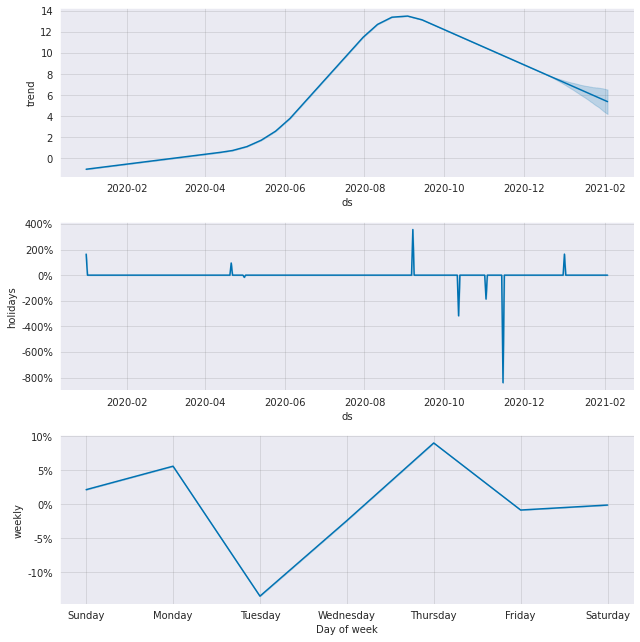

In [102]:
modelo_multiplicativo.plot_components(previsao);

# Comparando modelos pelo erro médio absoluto

In [105]:
previsao_multiplicativo = modelo_multiplicativo.predict(dataframe_futuro)

In [106]:
mean_absolute_error(df['y'], previsao_multiplicativo['yhat'][:350]).round(3)

2.138

# Análise Parcial

O modelo multiplicativo parece ter uma taxa de erro menor, ou seja, está predizendo os dados com mais exatidão

## Cross Validation (Validação Cruzada)

In [108]:
from fbprophet.diagnostics import cross_validation

In [111]:
janela = 1

In [109]:
df_cv = cross_validation(modelo_multiplicativo, initial = '180 days', period='30 days', horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-07-18 00:00:00 and 2020-11-15 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [112]:
cutoff = df_cv['cutoff'].unique()[janela]

In [113]:
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

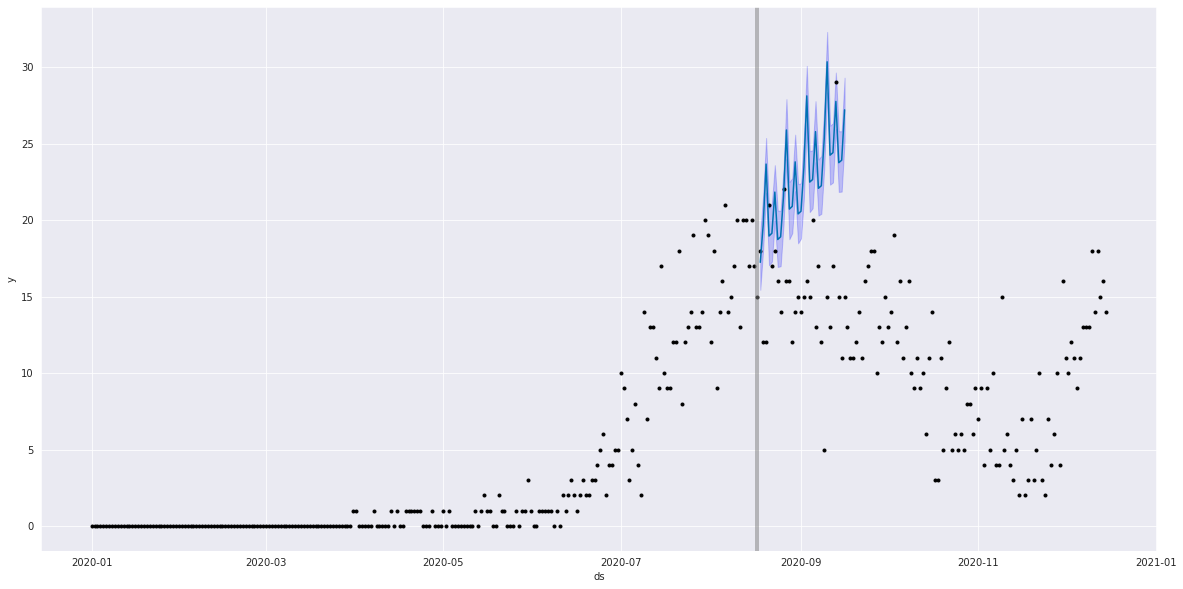

In [114]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(modelo_multiplicativo.history['ds'].values, modelo_multiplicativo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Avaliando Performance

In [115]:
from fbprophet.diagnostics import performance_metrics

In [116]:
df_p = performance_metrics(df_cv)

In [117]:
from fbprophet.plot import plot_cross_validation_metric

Text(0.5, 0, 'Tempo em dias')

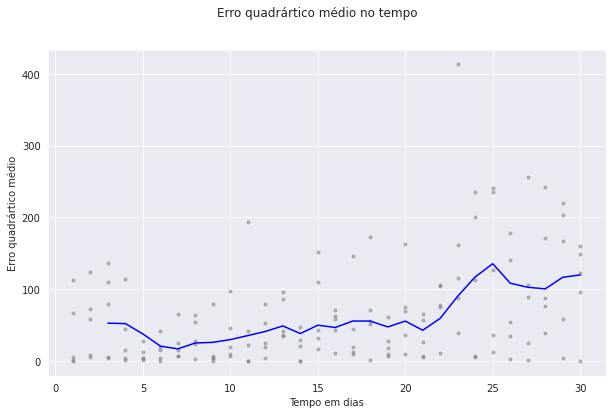

In [130]:
ax = plot_cross_validation_metric(df_cv, metric='mse');
ax.suptitle('Erro quadrártico médio no tempo')
plt.ylabel('Erro quadrártico médio')
plt.xlabel('Tempo em dias')


# Resultados

Os resultados demonstram uma tendência que queda do número de casos confirmados de COVID-19 no Mato Grosso do Sul a partir de agosto de 2020, permanecendo assim até o fim do ano.

O modelo conseguiu prever os valores com valores de erro bastante pequenos (erro médio quadrado de 2.138)